In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

#Langsmith Tracking And Tracing
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")

In [3]:
from langchain_groq import ChatGroq

model = ChatGroq(
    model="qwen-qwq-32b",
    max_tokens=512,
    temperature=0.1,
    top_p=0.95)

model.invoke("What is the capital of France?")

/Users/tusharshinde/code/my/AI/agentic_n_gen_ai/venv/lib/python3.13/site-packages/langchain_groq/chat_models.py:364: UserWarning: WARNING! top_p is not default parameter.
                    top_p was transferred to model_kwargs.
                    Please confirm that top_p is what you intended.
  warnings.warn(


AIMessage(content='\n<think>\nOkay, the user is asking, "What is the capital of France?" Let me think about how to approach this.\n\nFirst, I need to recall the basic geography facts. France is a country in Western Europe, and I remember that its capital is a major city. The most famous city in France that comes to mind is Paris. But wait, I should make sure I\'m not confusing it with another country. Let me verify.\n\nI know that Paris is often referred to as the "City of Light" and is known for landmarks like the Eiffel Tower and the Louvre Museum. That\'s definitely in France. But maybe there\'s a chance of mixing it up with another capital? Let me think of other major cities in France, like Marseille, Lyon, or Bordeaux. But none of those are capitals. The capital is indeed Paris.\n\nWait, could there be any exceptions or recent changes? I don\'t think so. The capital of France has been Paris for a long time. Let me check if there\'s any historical context where the capital might ha

In [4]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["question"],
    template="Answer the question: {question} in a single sentence."
)

In [5]:
chain = prompt | model

In [6]:
resp = chain.invoke({"question": "What is the capital of France?"})
print(resp.content)


<think>
Okay, the user is asking for the capital of France. Let me think. I remember that Paris is the capital. But wait, I should make sure there hasn't been any recent changes. No, capitals don't change like that. Also, sometimes people might confuse it with Lyon or Marseille, but no, Paris is definitely the capital. The question specifies a single sentence, so I need to be concise. Just state the answer clearly without any extra information. Let me check a reliable source in my mind. Yes, all sources confirm Paris. Alright, the answer is Paris.
</think>

The capital of France is Paris.


In [7]:
from langchain_core.output_parsers import JsonOutputParser

output_parser = JsonOutputParser()
format_instructions = output_parser.get_format_instructions()
format_instructions

'Return a JSON object.'

In [8]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["question"],
    template="Answer the question: {question} in a single sentence."
    " Return the answer in JSON format: {format_instructions}",
    partial_variables={"format_instructions": output_parser.get_format_instructions()},
)

In [9]:
model = ChatGroq(model="gemma2-9b-it")

chain = prompt | model | output_parser
response = chain.invoke({"question":"What is the captial of France?"})
print(response)

{'capital_of_france': 'Paris'}


In [10]:
from langchain_core.prompts import ChatPromptTemplate

chat_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant. Answer the question in a {format_instructions} format."),
        ("user", "{question}"),
    ]
)

chat_prompt


ChatPromptTemplate(input_variables=['format_instructions', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['format_instructions'], input_types={}, partial_variables={}, template='You are a helpful assistant. Answer the question in a {format_instructions} format.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['question'], input_types={}, partial_variables={}, template='{question}'), additional_kwargs={})])

In [11]:
chain = chat_prompt | model | output_parser
resp = chain.invoke({"question": "What is the capital of France?", "format_instructions": format_instructions})
print(resp)

{'capital_of_france': 'Paris'}


In [12]:
from langchain_community.document_loaders import TextLoader
loader = TextLoader("speech.txt")
documents = loader.load()

In [13]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
splitt_docs = text_splitter.split_documents(documents)

In [14]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
embedded_docs = embeddings.embed_documents([doc.page_content for doc in splitt_docs])


/Users/tusharshinde/code/my/AI/agentic_n_gen_ai/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from langchain_community.docstore.in_memory import InMemoryDocstore
import faiss
from langchain_community.vectorstores import FAISS

index=faiss.IndexFlatL2(384)

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vector_store.add_documents(splitt_docs)

['b504aa9b-6e0d-4d49-9446-cff196820976',
 '7c9069bc-7406-47dc-bd26-37008fe0fb71',
 '7b1369fb-619b-4cf2-a512-e79d27ae9c37',
 'bc0fe1a7-fa24-40ba-8d9f-7c0172a7287c',
 'c371370d-bc44-4b12-afc6-9018631bdcf1',
 '6203b2b0-a9da-4cba-8089-dc61cd34676b',
 'b6337eb9-87d6-4372-8df1-248ae56bb072',
 '4b81b85c-a725-4712-87a3-6d3976bf995f',
 '38d524d9-7e57-4a58-b4d5-bc5b23aca97d',
 '5ab466ab-4f1b-485c-abbf-3aacb75753e8']

In [16]:
vector_store.similarity_search("What is democracy?", k=1)

[Document(id='b504aa9b-6e0d-4d49-9446-cff196820976', metadata={'source': 'speech.txt'}, page_content='The world must be made safe for democracy. Its peace must be planted upon the tested foundations of political liberty. We have no selfish ends to serve. We desire no conquest, no dominion. We seek no indemnities for ourselves, no material compensation for the sacrifices we shall freely make. We are but one of the champions of the rights of mankind. We shall be satisfied when those rights have been made as secure as the faith and the freedom of nations can make them.')]

In [17]:
vector_store.save_local("faiss_index")

new_vector_store = FAISS.load_local("faiss_index", embeddings, allow_dangerous_deserialization=True)

new_vector_store.similarity_search("What is democracy?", k=1)

[Document(id='b504aa9b-6e0d-4d49-9446-cff196820976', metadata={'source': 'speech.txt'}, page_content='The world must be made safe for democracy. Its peace must be planted upon the tested foundations of political liberty. We have no selfish ends to serve. We desire no conquest, no dominion. We seek no indemnities for ourselves, no material compensation for the sacrifices we shall freely make. We are but one of the champions of the rights of mankind. We shall be satisfied when those rights have been made as secure as the faith and the freedom of nations can make them.')]

In [18]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 1})

In [19]:
retriever.invoke("What is democracy?")

[Document(id='b504aa9b-6e0d-4d49-9446-cff196820976', metadata={'source': 'speech.txt'}, page_content='The world must be made safe for democracy. Its peace must be planted upon the tested foundations of political liberty. We have no selfish ends to serve. We desire no conquest, no dominion. We seek no indemnities for ourselves, no material compensation for the sacrifices we shall freely make. We are but one of the champions of the rights of mankind. We shall be satisfied when those rights have been made as secure as the faith and the freedom of nations can make them.')]

In [41]:
from langchain.tools import tool

@tool
def weather(city: str)->str:
    """This tool provides weather of the cities"""
    if 'delhi' == city.lower():
        return "weather in delhi is sunny and 45 degrees"
    return f"weather in {city} is rainy and 22 degrees"

In [21]:
from langchain_groq import ChatGroq
llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)
response=llm.invoke("what is length of wall of china?")

In [22]:
tools = [weather]
llm_with_tools = llm.bind_tools(tools)

In [23]:
resp = llm_with_tools.invoke("what is weather in delhi")

In [24]:
resp.tool_calls

[{'name': 'weather',
  'args': {'city': 'Delhi'},
  'id': 'v2sfce60y',
  'type': 'tool_call'}]

In [25]:
from langgraph.graph import MessagesState

def call_llm(state: MessagesState):
    question = state['messages']
    resp = llm_with_tools.invoke(question)
    return {"messages": [resp]}

In [26]:
call_llm({"messages": "how r u?"})

{'messages': [AIMessage(content="I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you! How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 127, 'total_tokens': 236, 'completion_time': 0.54881345, 'prompt_time': 0.008236187, 'queue_time': 0.22104506699999998, 'total_time': 0.557049637}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--c70b6cfc-c072-47a3-b130-a10c9799db96-0', usage_metadata={'input_tokens': 127, 'output_tokens': 109, 'total_tokens': 236})]}

In [27]:
from langgraph.prebuilt import ToolNode
tool = ToolNode(tools)

In [28]:
from langgraph.graph import StateGraph, END, START

def router(state:MessagesState):
    last_message = state['messages'][-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [29]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

graph = StateGraph(MessagesState)

graph.add_node("call_my_llm", call_llm)
graph.add_node("mytools", tool)

graph.add_edge(START, "call_my_llm")
graph.add_conditional_edges("call_my_llm", 
                          router, {
                              "tools": "mytools",
                              END:END
                          })

graph.add_edge("mytools", "call_my_llm")

app = graph.compile(checkpointer=memory)

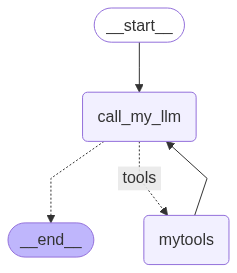

In [30]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": "1"}}

In [32]:
# resp = app.invoke({"messages": ["How are you"]})

for output in app.stream({"messages": ["How are you"]}, config=config):
    for key, val in output.items():
        print(key)
        print('--------------')
        print(val)
        print('\n')

call_my_llm
--------------
{'messages': [AIMessage(content='\nAlright, the user greeted me with "How are you." I need to respond appropriately. Since I\'m an AI, I don\'t have feelings, but I should acknowledge their greeting.\n\nI\'ll start by thanking them for asking. Then, I\'ll mention that I don\'t have feelings but am here and ready to help. I should keep it friendly and open-ended to encourage them to ask for assistance.\n\nI should avoid any markdown and keep the response natural. Let\'s make sure it\'s clear that I\'m here to help with whatever they need.\n</think>\n\nI\'m just a computer program, so I don\'t have feelings, but I\'m here and ready to help you with whatever you need! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 149, 'prompt_tokens': 126, 'total_tokens': 275, 'completion_time': 0.716740566, 'prompt_time': 0.011320165, 'queue_time': 0.22134315000000002, 'total_time': 0.728060731}, 'model_name': 'deeps

In [33]:
# resp = app.invoke({"messages": ["What is weather in Delhi?"]})
# resp

for output in app.stream({"messages": ["What is weather in Delhi?"]}, config=config):
    for key, val in output.items():
        print(key)
        print('--------------')
        print(val)
        print('\n')


call_my_llm
--------------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'h53y2rwe4', 'function': {'arguments': '{"city":"Delhi"}', 'name': 'weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 129, 'prompt_tokens': 171, 'total_tokens': 300, 'completion_time': 0.695360289, 'prompt_time': 0.018553906, 'queue_time': 0.222117699, 'total_time': 0.713914195}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--198cccdb-ba17-4219-8f82-5db4c7bbcc50-0', tool_calls=[{'name': 'weather', 'args': {'city': 'Delhi'}, 'id': 'h53y2rwe4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 171, 'output_tokens': 129, 'total_tokens': 300})]}


mytools
--------------
{'messages': [ToolMessage(content='weather in delhi is sunny and 45 degrees', name='weather', id='ba7a7a76-dc96-41f9-8df9-a6f9cee7c5f8', tool_call_id='h53y2rwe4')]}


call_my_llm
-

In [34]:
events = app.stream({"messages": ["What is weather in Delhi and can you suggest some hotels to stay in north Delhi?"]}, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()
    # print(event["messages"][-1])
    # print(event["messages"])

# resp = app.invoke({"messages": ["What is weather in Delhi and can you suggest some hotels to stay in north Delhi?"]})
# print(resp["messages"])

================================ Human Message =================================

What is weather in Delhi and can you suggest some hotels to stay in north Delhi?
================================== Ai Message ==================================
Tool Calls:
  weather (73agvarqc)
 Call ID: 73agvarqc
  Args:
    city: Delhi
================================= Tool Message =================================
Name: weather

weather in delhi is sunny and 45 degrees
================================== Ai Message ==================================

The weather in Delhi is sunny and 45 degrees. 

As for hotels in North Delhi, here are a few suggestions:
1. **The Oberoi, New Delhi** - A luxurious option with excellent service.
2. **The Leela Palace New Delhi** - Offers a blend of luxury and comfort.
3. **The Grand New Delhi** - A modern hotel with great amenities.
4. **JW Marriott Hotel New Delhi Aerocity** - Known for its excellent service and facilities.
5. **Andaz Delhi - A Concept by Hyatt** - A s

In [35]:
memory.get(config)

{'v': 3,
 'ts': '2025-06-26T03:00:12.272015+00:00',
 'id': '1f05239a-d4ec-67e6-800b-8e23bbb6f9aa',
 'channel_versions': {'__start__': '00000000000000000000000000000010.0.5423751145710171',
  'messages': '00000000000000000000000000000013.0.4752633416822538',
  'branch:to:call_my_llm': '00000000000000000000000000000013.0.3432796371128357',
  'branch:to:mytools': '00000000000000000000000000000012.0.9511541941057224'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000009.0.8371129625232513'},
  'call_my_llm': {'branch:to:call_my_llm': '00000000000000000000000000000012.0.019181171513335538'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000011.0.3490439775390003'}},
 'channel_values': {'messages': [HumanMessage(content='How are you', additional_kwargs={}, response_metadata={}, id='aaf330c9-c0c2-400d-8140-969bd2c84732'),
   AIMessage(content='\nAlright, the user greeted me with "How are you." I need to respond appropriately. Sinc

In [36]:
events = app.stream({"messages": ["In which city tempratur is 45 "]}, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

In which city tempratur is 45 
================================== Ai Message ==================================

The temperature in Delhi is currently 45 degrees. Let me know if you'd like more details about the weather or any other assistance!


In [ ]:
@tool
def multiply(a:int, b:int)->int:
    """This function multiply two integer argumets a * b and return multiplication result as an integer"""
    return a * b

@tool
def add(a:int, b:int)->int:
    """This function adds two integer argumets a * b and return addition result as an integer"""
    return a + b

@tool
def devide(a:int, b:int)->float:
    """This function devides two integer argumets a / b and return division as float"""
    return a / b


In [107]:
from yfinance import Tickers

@tool
def get_stock_price(ticker: str):
    """Return stock price of ticker"""
    tickers = Tickers(ticker)
    return tickers.tickers[ticker].info.get("previousClose")

In [104]:
get_stock_price("TSLA")

340.47

In [44]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [112]:
more_tools = [multiply, add, devide, search, get_stock_price]

llm_with_tools = llm.bind_tools(tools=more_tools)

SYSTEM_PROMPT = "You are a helpful AI assitance, answering users query with search and arithmetic input"

def llm_node(state:MessagesState):
    query = state["messages"]
    prompt = [SYSTEM_PROMPT] + query
    resp = llm_with_tools.invoke(prompt)
    return {"messages": [resp]}

In [113]:
from langgraph.prebuilt import tools_condition

graph = StateGraph(MessagesState)

graph.add_node("my_llm_node", llm_node)
graph.add_node("tools", ToolNode(more_tools))

graph.add_edge(START, "my_llm_node")
graph.add_conditional_edges("my_llm_node", tools_condition)
graph.add_edge("tools", "my_llm_node")

react_graph = graph.compile()


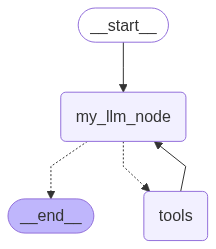

In [114]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [115]:
from langchain_core.messages import HumanMessage, SystemMessage
message = [HumanMessage(content="Multiply Narendra Modi's age with 2")]
react_graph.invoke({"messages": message})

{'messages': [HumanMessage(content="Multiply Narendra Modi's age with 2", additional_kwargs={}, response_metadata={}, id='f9f0a511-3fbc-449c-b9ba-66ffe7716497'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'x91s1ej87', 'function': {'arguments': '{"query":"Narendra Modi age 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 110, 'prompt_tokens': 377, 'total_tokens': 487, 'completion_time': 0.479268705, 'prompt_time': 0.025822631, 'queue_time': 0.22120063299999998, 'total_time': 0.505091336}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8204b949-cf11-48c2-9e7d-648046832ab4-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Narendra Modi age 2023'}, 'id': 'x91s1ej87', 'type': 'tool_call'}], usage_metadata={'input_tokens': 377, 'output_tokens': 110, 'total_tokens': 487}),
  ToolMessage(conte

In [122]:
from langchain_core.messages import HumanMessage, SystemMessage
message = [HumanMessage(content="add 200 to the stock price of TSLA and then multiply result by 2")]
react_graph.invoke({"messages": message})

{'messages': [HumanMessage(content='add 200 to the stock price of TSLA and then multiply result by 2', additional_kwargs={}, response_metadata={}, id='805f0e21-1386-4d24-a5ef-5460c5cba6db'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '674qebtdk', 'function': {'arguments': '{"ticker":"TSLA"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 237, 'prompt_tokens': 387, 'total_tokens': 624, 'completion_time': 0.861818182, 'prompt_time': 0.032880549, 'queue_time': 0.219026607, 'total_time': 0.894698731}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d60bd54f-77c8-4d1f-81c0-ea392f11f2d7-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'TSLA'}, 'id': '674qebtdk', 'type': 'tool_call'}], usage_metadata={'input_tokens': 387, 'output_tokens': 237, 'total_tokens': 624}),
  ToolMessage(content='340.47', name